# CS110 Final Project - Plagiarism Detector

In [1]:
NAME = 'William Nguyen'
COLLABORATORS = 'Ha, Catherine'

## Question 1: Rolling Hashing

### My approach:

1. I have a function to clean all weird or disturbing symbols in the inputs so that the string comparison can be dealt with more easily

2. I have two functions to calculate hash value for each k-long slice of the two strings. The first one calculates the initial window. And then for the rest, we only have to roll another next character and calculate based on the previous window.

3. My rolling hashing implementation takes in 4 arguments: 2 strings, the base in calculation and the hash table size (or q). I chose 26 as the base in the hash value calculation because there can be only 26 distinct characters after cleaning the string. The higher the base, the less likelihood windows get the same position. Therefore, to balance between space the hash table consumes and few collision in the tables, 26 seems fine to work on. Furthermore, I also chose the hash table size to be q because this ensures all hash values will be in the hash table. In the division method, we need to take the remainder to simplify our hash value, yet still try to assign windows to distinct positions. Therefore, the divisor should be a prime number to minimize collisions. The bigger the hash table size, the more chance for all windows to fall into different positions. However, we also need to beware of space consumption. In my first attempt, I will choose the hash table to be 97 because it is the largest 2-digit prime number. This initial choice helped me debug better and verify my results. Later on, I will conduct experiments to visualize the bahavior of changes in collisions with different prime numbers and choose the hash table size thanks to this.

4. For data structure, I intend to use a dictionary serving as the hash table. Dictionary really works because it is easy and only takes constant time to insert, search and extract things. To specify, we map value (the window of inputted string) to the corresponding key (the hash value - position in the hash table) so that we can save time in string comparison. Unlike the naive approach which compares all possible combinations in the inputs, the hash table allows us to only compare substrings with the same hash value. Therefore, after putting all k-length substrings of x into the hash table with their hash values, we can calculate hash values of y substrings and only have to examine similarities with x substrings with the same hash values. This is more efficient in runtime because we are down to the comparison of hash value before string matching. Therefore, few collisions can even make the algorithm better. In this problem, choosing a heap or a kind of tree will no longer be appropriate because we have no demands of sorting substrings according to their values or something. Furthermore, for heaps, it takes O(log n) to insert new substrings into the heap because of maintaining heap properties and O(n) to search for substring in the heap in the worst case scenario with n as the number of inputs. Likewise, extracting information out of the heap or a Binary Search Tree is also computationally expensive with O(h) with h being the height of the tree or the heap. O(h) tends to be O(log n) in average case, but can also reach O(n) in the worst case . All search and insert operations in a dictionary only takes O(1) time.

5. When collisions happen, I will use chaining to address this problem because I want to take full advantage of dictionary or list data structure. In the dictionary or the hash table, with the key (the hash value), I will include a list of values (substrings of the input). As a result, when collisions happen, I just append this substring to this list at that hash value. This is actually easy to handle because when I want to examine the y string to detect plagiarism, I can easily use dictionary and list to search for information in constant time.

6. For my algorithmic strategy, instead of comparing the string directly, I will compute hash values for each substring and only compare those with the same hash values. This is more computationally efficient because it reduces redundant comparisons. In other words, with a filtering step before the actual comparison, I can only focus on potential candidates for string matching.

    - First, I will preprocess inputs to ensure clear strings without disturbing aspects
    - Then, I calculate hash value for the first substring by the division method which uses the modulus
    - After that, I recursively roll to the next character, calculate the next hash value based on the previous substring's hash value
    - After putting all substrings of x into their positions in the hash table, I turn to the y substring
    - This time, I compute the hash value of y substring and immediately check if at that position, there is any x substring there
    - If yes, I will compare the y-substring and if this is a match, I add their x - y positions into the result list
    - This process happens recursively until I scan through the entire y-list to ensure no string match is missed
    
To evaluate, this method will definitely work better than the brute force approach because it saves time in making reasonable comparisons.

In [2]:
def cleaning(text):
    """
    Preprocess the inputted string for plagiarism detection, remove all unusual or distracting characters

    Input
    ------
    text: the string itself

    Output
    ------
    str
        the cleaned version of the text
    """
    # lowercase all characters
    text = text.lower()
    ans = ''
    for char in text:
        # only accept normal letters
        if char.isalpha():
            ans += char
    return ans

assert cleaning('Hello everyone! I am William!!!!') == 'helloeveryoneiamwilliam'

In [3]:
def first_hashcode(text, base = 26, size = 97):
    """
    Compute the hash value of the initial window

    Inputs
    ------
    text: str
        the substring
    base: int
        the base in our calculation
    size: int
        the hash table size or the modulus - division method
  
    Output
    ------
    int
        the hash value of the initial window

    """
    # initialize
    value = 0
    for i in range(len(text)):
        value += ord(text[-i-1])*(base**i)
    # get the remainder
    position = value % size
    return position



william_test = ord('w')*26**6 + ord('i')*26**5 + ord('l')*26**4 + ord('l')*26**3 + ord('i')*26**2 + ord('a')*26**1 + ord('m')*26**0

assert william_test % 97 == first_hashcode('william', 26, 97)

In [4]:
def rolling_hashcode(text, new_symbol, base = 26, size = 97):
    """
    Rolling hash to compute all hash values

    Inputs
    ------
    text: str
        the substring
    new_symbol: str
        the rolled charactere
    base: int
        the base in our calculation
    size: int
        the hash table size or the modulus - division method

    Output
    ------
    hash value: int
        hash value of the next windows after rolling a new character
    """
    # get the hash value of the previous window
    value = first_hashcode(text, base, size)
    # first letter to be eliminated
    subtraction = ord(text[0])*base**(len(text))
    # move the whole hash value to the next order and add the new symbol at the lowest order
    cumulative_value = (value*base + ord(new_symbol)) % size
    # minus the beginning letter
    final_value = (cumulative_value - subtraction % size) %size

    return final_value % size

assert rolling_hashcode('william', 's', 26, 97) == first_hashcode('illiams', 26, 97)

In [5]:
def rh_get_match(x, y, k, size = 97):
    """
    Finds all common length-k substrings of x and y using rolling hashing on both strings.

    Inputs
    ------
        - x, y: strings
        - k: int, length of substring
        - size: int, the hash table size

    Output
    ------
        - A list of tuples (i, j) where x[i:i+k] = y[j:j+k]
        - dict: The hash table
    """
    # an empty list storing tuples
    results = []
    base = 26
    # cleaning strings
    x, y = cleaning(x), cleaning(y)

    # get an empty hash table
    hashtable = {}

    for i in range(size):
        hashtable[i] = []
    # edge case
    if len(x) < k or len(y) < k:
        return None

    # compute hash value for the first substring
    x_string = x[:k]
    x_pos = first_hashcode(x_string, base, size)

    # loop over the entire x-string
    for i in range(len(x) - k + 1):

        # put it to its position in the hash table
        if not hashtable[x_pos]:
            hashtable[x_pos] = [(x_string, i)]

        # if there is collision, use chaining
        else:
            hashtable[x_pos].append((x_string, i))
            
        # move to the next substring and still stay inside the loop
        if i < len(x) - k:
            x_pos = rolling_hashcode(x_string, x[i+k], base, size)
            x_string = x_string[1:] + x[i+k]

    # compute hash value for the first y-substring
    y_string = y[:k]
    y_pos = first_hashcode(y_string, base, size)

    # loop over the entire y-string
    for j in range(len(y) - k + 1):

        # if at that position, there are x-substrings
        if hashtable[y_pos]:
            # compare y-substring with the same hash value with x-substrings there
            for candidate in hashtable[y_pos]:
                if candidate[0] == y_string:
                    # add to the result list
                    results.append((candidate[1], j))
        # move to the next y-substring
        if j < len(y) - k:
            y_pos = rolling_hashcode(y_string, y[j+k], base, size)
            y_string = y_string[1:] + y[j+k]
      
    # return the hash table for future examination and the list of tuples
    return hashtable, results

# Test case 1: simple and short
x = 'Today is Monday'
y = 'day'

# with small string, k should be small to engage more closely with inputs
# i also reduce the hash table size because we do not need much space for small strings
assert rh_get_match(x, y, 3, 15)[1] == [(2, 0), (10, 0)]

In [6]:
# Test case 2: there is little effort in paraphrasing

x = 'This is an amazing HC to contrast the performance of multiple algorithms by experimental analysis, specifically #ComputationalCritique. \
  With the randoization of the inputs at different lengths, we can reduce the likelihood of worst case, thus increasing the validity of our comparison \
  between the runtime of distinct algorithms. We need the best way to store results of runtime with insanely large inputs and portray the scaling behaviour \
  in running time of algorithms. A data visualization would be most suitable to communicate this message to the audience. This not only simplifies nuances \
  in the scaling behaviour of the algorithms with larger inputs but also captures an intuitive understanding for readers so that audience can easily understand \
  which algorithm works faster in real life. '

y = 'This is a very helpful HC in contrasting the performance between different algorithms by experimental results, specifically #ComputationalCritique. \
  With randomized inputs of different lengths, we can eliminate weird low likelihood of worst case or best case scenarios, thus increasing the validity of \
  our comparison between the runtime of different algorithms. We need the best way to accommodate results of the runtime with insanely large inputs and portray the \
  scaling behaviour in the runtime, a data visualization would be best to communicate this idea to the audience. This not only simplifies different nuances \
  in the scaling behaviour of the algorithm when inputs get bigger but also captures an intuitive understanding for readers so that anyone looking at can \
  understand which algorithm is faster or in real life, when these algorithms deal with thousands of data points, how the runtime growth can become.'

# with longer strings like paragraphs, I set k to be 15 which involves around 2-3 words
# this makes more sense because in two paragraphs, we can easily find similar 3 contiguous characters, yet not
# correctly identify plagiarism. instead, 2-3 words can imply the same meaning.
rh_get_match(x, y, 15, 97)[1]

[(51, 63),
 (52, 64),
 (53, 65),
 (54, 66),
 (55, 67),
 (56, 68),
 (57, 69),
 (58, 70),
 (59, 71),
 (60, 72),
 (82, 93),
 (83, 94),
 (84, 95),
 (85, 96),
 (86, 97),
 (87, 98),
 (88, 99),
 (89, 100),
 (90, 101),
 (91, 102),
 (92, 103),
 (93, 104),
 (94, 105),
 (95, 106),
 (96, 107),
 (97, 108),
 (98, 109),
 (99, 110),
 (100, 111),
 (101, 112),
 (102, 113),
 (103, 114),
 (104, 115),
 (105, 116),
 (148, 149),
 (149, 150),
 (150, 151),
 (151, 152),
 (152, 153),
 (153, 154),
 (154, 155),
 (178, 187),
 (179, 188),
 (180, 189),
 (181, 190),
 (182, 191),
 (183, 192),
 (184, 193),
 (199, 227),
 (200, 228),
 (201, 229),
 (202, 230),
 (203, 231),
 (204, 232),
 (205, 233),
 (206, 234),
 (207, 235),
 (208, 236),
 (209, 237),
 (210, 238),
 (211, 239),
 (212, 240),
 (213, 241),
 (214, 242),
 (215, 243),
 (216, 244),
 (217, 245),
 (218, 246),
 (219, 247),
 (220, 248),
 (221, 249),
 (222, 250),
 (223, 251),
 (224, 252),
 (225, 253),
 (226, 254),
 (227, 255),
 (228, 256),
 (229, 257),
 (230, 258),
 (231

In [7]:
# Test case 3: The second string learns content from the first one and rewrites everything
x = 'Market failure refers to inefficiency in the production and distribution of goods and services. \
    To specify, the allocation of products fails to meet the demand and affordability of consumers \
    nor cause consumers to be better off, which means the problem of availability, satisfaction, \
    and cost-effectiveness. Due to asymmetric information between physicians and patients, externalities \
    from producing drugs or taking communicable medicines, and market power derived from patents, \
    the pharmaceutical industry, with sharp differences from neoclassical theory, is prone to inequity \
    and inability to guarantee public health and invites crucial solutions, namely government regulations \
    and subsidies'

y = 'When it comes to market failure, we mean sluggish production and allocation of resources to the society. \
To elaborate, consumers either fail to pay for the goods they need or cannot reach their desired products \
due to scarcity or geographical constraints. As a result, the pleasure as well as welfare of the public is \
limited. Reasons for this phenomenon include informational assymetry or externalities that influence the price \
determination. The sector bearing typical qualities of room for market failure is pharmaceutical industry where \
imbalance in knowledge between patients and physicians happen. These implications are deleterious due to \
social inequality and health risks, thus calling for appropriate governmental intervention'


rh_get_match(x, y, 15, 97)[1]

[(405, 424),
 (406, 425),
 (407, 426),
 (408, 427),
 (409, 428),
 (410, 429),
 (411, 430),
 (412, 431),
 (413, 432)]

### Evaluation:

The code works pretty well. For the first test case, it prints out the correct result as expected in the prompt. For the second and third case, we can see that plagiarism appears more in the second test case while in the third one, the writer tries to get the core idea and develop with his own writing style. As a result, results in two test cases differ considerably.

### Experiments to try out different prime numbers for our hash table size:



As presented above, the divisor should be prime number and the hash table size because this will:

1. Ensure all substrings' hash values fall into positions within the hash table size
2. Minimize collisions

Therefore, I need to have more functions to print out a list of prime numbers within a given range and to calculate metrics showcasing the collision phenomenon in our algorithm.


In [8]:
def isPrime(number):
    """
    Check if a number if a prime number

    Input
    -----
    number: the number

    Output
    ------
    bool: return True if the number is a prime number, False otherwise
    """
    # we only have to examine from 2 to the square root of the number
    for i in range(2, int(number**0.5) + 1):
        # if it is divisible by a number within that range, its not a prime
        if number % i == 0:
            return False
    return True


def prime_numbers(lower_bound, upper_bound):
    """
    Compute a list of prime numbers within a range

    Inputs
    ------
    - lower_bound, upper_bound: int
        The two endpoints of a range

    Output
    ------
    list: a list of prime numbers

    """
    lst = []
    for num in range(lower_bound, upper_bound+1):
        # use the above function
        if isPrime(num):
            lst.append(num)
    return lst

assert prime_numbers(2, 100) == [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]

In [9]:
def collisions(hashtable):
    """
    Compute the collision rate and average capacity in one slot of the hash table

    Input:
        - dict: The hash table computed above when comparing two strings for plagiarism detection

    Outputs:
        - tuple: (a, b)
        a, b: int - the average capacity and collision rate
    """
    # initialize
    filled_slot = 0
    num_occupied = 0
    overfilled_slot = 0
    # loop through the hash table
    for i in hashtable:
        # nonempty slots
        if len(hashtable[i]) >= 1:
            # sum the total substrings
            num_occupied += len(hashtable[i])
            # calculate the number of nonempty slots
            filled_slot += 1

        # if there is collision
        if len(hashtable[i]) > 1:
            # calculate the number of overfilled slots
            overfilled_slot += 1
      
      
    
    average_capacity = num_occupied / filled_slot
    collision_rate = overfilled_slot / filled_slot

    return (round(average_capacity, 2), round(collision_rate, 2))

x = 'Today is Monday'
y = 'day'
# try out printing the collision metrics
collisions(rh_get_match(x, y, 3, 15)[0])

(1.57, 0.57)

In [10]:
x = 'This is an amazing HC to contrast the performance of multiple algorithms by experimental analysis, specifically #ComputationalCritique. \
  With the randoization of the inputs at different lengths, we can reduce the likelihood of worst case, thus increasing the validity of our comparison \
  between the runtime of distinct algorithms. We need the best way to store results of runtime with insanely large inputs and portray the scaling behaviour \
  in running time of algorithms. A data visualization would be most suitable to communicate this message to the audience. This not only simplifies nuances \
  in the scaling behaviour of the algorithms with larger inputs but also captures an intuitive understanding for readers so that audience can easily understand \
  which algorithm works faster in real life. '

y = 'This is a very helpful HC in contrasting the performance between different algorithms by experimental results, specifically #ComputationalCritique. \
  With randomized inputs of different lengths, we can eliminate weird low likelihood of worst case or best case scenarios, thus increasing the validity of \
  our comparison between the runtime of different algorithms. We need the best way to accommodate results of the runtime with insanely large inputs and portray the \
  scaling behaviour in the runtime, a data visualization would be best to communicate this idea to the audience. This not only simplifies different nuances \
  in the scaling behaviour of the algorithm when inputs get bigger but also captures an intuitive understanding for readers so that anyone looking at can \
  understand which algorithm is faster or in real life, when these algorithms deal with thousands of data points, how the runtime growth can become.'


collisions(rh_get_match(x, y, 15, 97)[0])

(6.69, 0.99)

In [11]:
x = 'Market failure refers to inefficiency in the production and distribution of goods and services. \
    To specify, the allocation of products fails to meet the demand and affordability of consumers \
    nor cause consumers to be better off, which means the problem of availability, satisfaction, \
    and cost-effectiveness. Due to asymmetric information between physicians and patients, externalities \
    from producing drugs or taking communicable medicines, and market power derived from patents, \
    the pharmaceutical industry, with sharp differences from neoclassical theory, is prone to inequity \
    and inability to guarantee public health and invites crucial solutions, namely government regulations \
    and subsidies'

y = 'When it comes to market failure, we mean sluggish production and allocation of resources to the society. \
To elaborate, consumers either fail to pay for the goods they need or cannot reach their desired products \
due to scarcity or geographical constraints. As a result, the pleasure as well as welfare of the public is \
limited. Reasons for this phenomenon include informational assymetry or externalities that influence the price \
determination. The sector bearing typical qualities of room for market failure is pharmaceutical industry where \
imbalance in knowledge between patients and physicians happen. These implications are deleterious due to \
social inequality and health risks, thus calling for appropriate governmental intervention'

collisions(rh_get_match(x, y, 15, 97)[0])

(5.9, 0.96)

As can be observed from the collision rate and average capacity of each slot, the apropriate hash table size seems dependent on the length of inputted strings. In the first test case, with a larger hash table size than string lengths, the collision rate is pretty small. In contrast, in the other two test cases, the collision rate nearly reaches 1, which means almost all buckets in the hash table contain more than one substring. And with more plagiarism in the second test case, each bucket stores more substrings than in the third test case

With these insights from the analysis, I would love to conduct more experiments with different prime numbers - hash table sizes - on the second test case because with greater plagiarism, more collisions are likely.

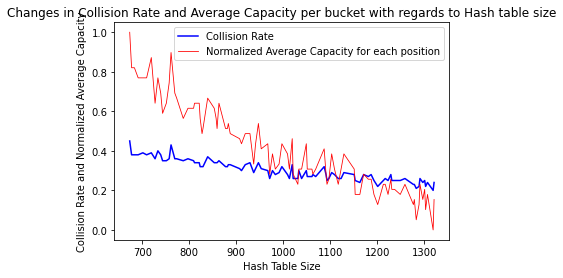

Length of cleaned inputted string 663
Potential sizes: [1283, 1319]


In [12]:
import matplotlib.pyplot as plt
import numpy as np


x = 'This is an amazing HC to contrast the performance of multiple algorithms by experimental analysis, specifically #ComputationalCritique. \
  With the randoization of the inputs at different lengths, we can reduce the likelihood of worst case, thus increasing the validity of our comparison \
  between the runtime of distinct algorithms. We need the best way to store results of runtime with insanely large inputs and portray the scaling behaviour \
  in running time of algorithms. A data visualization would be most suitable to communicate this message to the audience. This not only simplifies nuances \
  in the scaling behaviour of the algorithms with larger inputs but also captures an intuitive understanding for readers so that audience can easily understand \
  which algorithm works faster in real life. '

y = 'This is a very helpful HC in contrasting the performance between different algorithms by experimental results, specifically #ComputationalCritique. \
  With randomized inputs of different lengths, we can eliminate weird low likelihood of worst case or best case scenarios, thus increasing the validity of \
  our comparison between the runtime of different algorithms. We need the best way to accommodate results of the runtime with insanely large inputs and portray the \
  scaling behaviour in the runtime, a data visualization would be best to communicate this idea to the audience. This not only simplifies different nuances \
  in the scaling behaviour of the algorithm when inputs get bigger but also captures an intuitive understanding for readers so that anyone looking at can \
  understand which algorithm is faster or in real life, when these algorithms deal with thousands of data points, how the runtime growth can become.'


# get all candidates of prime numbers to test out
# lower bound is the length of the string to ensure low collision rate
# to avoid taking up too much space, i put the upper bound to be double the string length
potential_size = prime_numbers(len(cleaning(x)), len(cleaning(x)) * 2)

collision = []
avg_capacity = []
optimal_size = []
for size in potential_size:
    # store all collision rates and average capacity of buckets into two lists
    
    # get the first thing in the tuple of rh_get_match - the hash table
    avg_capacity.append(collisions(rh_get_match(x, y, 15, size)[0])[0])
    collision.append(collisions(rh_get_match(x, y, 15, size)[0])[1])

    # because we examine string matching within the substring's position, we care about low average capacity in a slot
    if collisions(rh_get_match(x, y, 15, size)[0])[0] <= 1.25:
        optimal_size.append(size)
        
# normalize the average capacity in each bucket to be within the range from 0 to 1
avg_capacity = np.array(avg_capacity)
normalized_avg_capacity = (avg_capacity - min(avg_capacity)) / (max(avg_capacity) - min(avg_capacity))

plt.plot(potential_size, collision, label = 'Collision Rate', color = 'blue')
plt.plot(potential_size, normalized_avg_capacity, label = 'Normalized Average Capacity for each position', color = 'red', linewidth = 0.8)
plt.xlabel('Hash Table Size')
plt.ylabel('Collision Rate and Normalized Average Capacity')
plt.title('Changes in Collision Rate and Average Capacity per bucket with regards to Hash table size')
plt.legend()
plt.show()
print("Length of cleaned inputted string", len(cleaning(x)))
print("Potential sizes:", optimal_size)

From the experiment above, we can clearly see that both metrics reduce as the hash table size grows. This is very good for string matching. Furthermore, we can see that there are two potential numbers of q we can choose - 1283 and 1319. I will choose to take 1319 to optimize the chance of avoiding collisions in my hash table

In [13]:
x = 'This is an amazing HC to contrast the performance of multiple algorithms by experimental analysis, specifically #ComputationalCritique. \
  With the randoization of the inputs at different lengths, we can reduce the likelihood of worst case, thus increasing the validity of our comparison \
  between the runtime of distinct algorithms. We need the best way to store results of runtime with insanely large inputs and portray the scaling behaviour \
  in running time of algorithms. A data visualization would be most suitable to communicate this message to the audience. This not only simplifies nuances \
  in the scaling behaviour of the algorithms with larger inputs but also captures an intuitive understanding for readers so that audience can easily understand \
  which algorithm works faster in real life. '

y = 'This is a very helpful HC in contrasting the performance between different algorithms by experimental results, specifically #ComputationalCritique. \
  With randomized inputs of different lengths, we can eliminate weird low likelihood of worst case or best case scenarios, thus increasing the validity of \
  our comparison between the runtime of different algorithms. We need the best way to accommodate results of the runtime with insanely large inputs and portray the \
  scaling behaviour in the runtime, a data visualization would be best to communicate this idea to the audience. This not only simplifies different nuances \
  in the scaling behaviour of the algorithm when inputs get bigger but also captures an intuitive understanding for readers so that anyone looking at can \
  understand which algorithm is faster or in real life, when these algorithms deal with thousands of data points, how the runtime growth can become.'


collisions(rh_get_match(x, y, 15, 1319)[0])

(1.22, 0.2)

In [14]:
x = 'Market failure refers to inefficiency in the production and distribution of goods and services. \
    To specify, the allocation of products fails to meet the demand and affordability of consumers \
    nor cause consumers to be better off, which means the problem of availability, satisfaction, \
    and cost-effectiveness. Due to asymmetric information between physicians and patients, externalities \
    from producing drugs or taking communicable medicines, and market power derived from patents, \
    the pharmaceutical industry, with sharp differences from neoclassical theory, is prone to inequity \
    and inability to guarantee public health and invites crucial solutions, namely government regulations \
    and subsidies'

y = 'When it comes to market failure, we mean sluggish production and allocation of resources to the society. \
To elaborate, consumers either fail to pay for the goods they need or cannot reach their desired products \
due to scarcity or geographical constraints. As a result, the pleasure as well as welfare of the public is \
limited. Reasons for this phenomenon include informational assymetry or externalities that influence the price \
determination. The sector bearing typical qualities of room for market failure is pharmaceutical industry where \
imbalance in knowledge between patients and physicians happen. These implications are deleterious due to \
social inequality and health risks, thus calling for appropriate governmental intervention'

collisions(rh_get_match(x, y, 15, 1319)[0])

(1.26, 0.2)

After trying out with the same test cases, we can see that the collision rate drops dramatically. Likewise, a bucket in the table will now averagely contain fewer substrings.

## Question 2: Regular Hashing

### My approach:

Before, we applied rolling hashing with the division method which is simple to implement by only taking a remainder in one calculation. We also explored that if we increased the divisor, aka the hash table size, to a bigger prime number than the inputted string length, the collision rate will reduce. However, a really big hash table size can consume too much unnecessary space and we are now interested in complicating our hash function to minimize collisions right in our calculation. Therefore, we are facing a trade off here. We want to save space consumption, yet will have to sacrifice a simplified hash function and waste more time computing hash vaues for substrings. 



***Reflection on what makes a good hash function:***

With close engagement and multiple experiments on rolling hashing, I derive that a good hash function should first effectively compute the values for substrings and then distribute substrings evenly or uniformly to different positions in the hash table. With uniform distribution, collisions will rarely happen, which speeds up our process of searching for the position and examine string matching.

Therefore, in this second attempt, I intend to make only changes in the hash functions compared to the rolling hashing. First, for the hash value calculation, I would love to apply multiplication method thanks to external research (Cormen et al. Section 11.3, 1989). From our implementation in the first question, I derive that the more random our calculation of hash values becomes, the fewer collision will happen because same hash values will now only happen to similar strings. Therefore, I will not simply take a modulus now but will multiply with a real number ranging from 0 to 1. I consulted in the textbook and realized that 0.618 is an effective number. I made a few modifications to the first_hashcode function by removing the modulus calculation. Furthermore, I time this with 0.618 to get an interesting decimal number. Then, I will get only the decimal part to maximize differences, time this with the hash table size which will be discussed later and round this to an integer. This complicated calculation is supposed to reduce collisions and improve on the runtime of the algorithm. For the rest, I will keep the same with rolling hashing approach because the mechanism of two algorithms differs only in the calculation of hash values to put substrings into positions more effectively.

I will still apply dictionary and list data structures because of their advantages over inserting, searching and extracting information. This does not change much from the rolling hashing implementation.

In [15]:
# In the division method, with a simple test case of "Today is Monday" and "day", there can still be 
# spurious hits even when substrings are not similar. For this reason, we hope to minimize these regrettable
# collisions with the multiplication method. 

assert first_hashcode('ayi') == first_hashcode('mon')

In [16]:
import math
def hash_function(text, base = 26, size = 1319):
    """
    Compute the hash value of all windows with base 26 and no division method

    Input
    -----
    str
        the substring
  
    Output
    ------
    int
        the hash value
    """
    
    value = 0
    for i in range(len(text)):
        value += ord(text[-i-1])*(base**i)
    # Cormen et al. Section 11.3 
    a = (math.sqrt(5) - 1)/2
  
    position = math.floor(size * ((value * a) % 1 )) 
    return position

a = (math.sqrt(5) - 1)/2

old_hash_value = ord('w')*26**6 + ord('i')*26**5 + ord('l')*26**4 + ord('l')*26**3 + ord('i')*26**2 + ord('a')*26**1 + ord('m')*26**0

william = 1319 * ((old_hash_value * a) % 1)

assert hash_function('william') == math.floor(william)

In [17]:
def regular_get_match(x, y, k, size = 1319):
    """
    Finds all common length-k substrings of x and y 
    NOT using rolling hashing on both strings.

    Inputs
    ------
    str
        x, y: strings to detect plagiarism

    int
        k: the length of substrings
  
    Output
    ------
    a tuple of
        - the hash table
        - a list of tuples (i, j) where x[i:i+j] ==  y[j:j+k]
    """
    # initialize 
    base = 26
    results = []
    x, y = cleaning(x), cleaning(y)

    # get an empty hash table
    hashmap = {}

    for i in range(size):
        hashmap[i] = []

    # edge case
    if len(x) < k or len(y) < k:
        return None
    # because we dont use rolling hashing, we put things into a loop
    for i in range(len(x) - k + 1):
        # get a substring and compute its position - hash value
        x_string = x[i:i+k]
        x_pos = hash_function(x_string, base, size)
        
        # put it into the right position
        if hashmap[x_pos] == None:
            hashmap[x_pos] = [(x_string, i)]

        # use chaining to fix collisions
        else:
            hashmap[x_pos].append((x_string, i))

    # loop over the y-string
    for j in range(len(y) - k + 1):

        # get a substring and compute its position - hash value
        y_string = y[j:j+k]
        y_pos = hash_function(y_string, base, size)

        # at the y-substring's position, if there are x-substrings, compare!
        if hashmap[y_pos]:
            for candidate in hashmap[y_pos]:
                # if there is a match, add it and its index to the result 
                if candidate[0] == y_string:
                    results.append((candidate[1], j))
    # return the table and the list of tuples
    return hashmap, results

# test case 1: simple and short
x = 'Today is Monday'
y = 'day'

# with small string, k should be small to engage more closely with inputs
# i also reduce the hash table size because we do not need much space for small strings
assert regular_get_match(x, y, 3)[1] == [(2, 0), (10, 0)]

In [18]:
# Test case 2: there is little effort in paraphrasing
x = 'This is an amazing HC to contrast the performance of multiple algorithms by experimental analysis, specifically #ComputationalCritique. \
  With the randoization of the inputs at different lengths, we can reduce the likelihood of worst case, thus increasing the validity of our comparison \
  between the runtime of distinct algorithms. We need the best way to store results of runtime with insanely large inputs and portray the scaling behaviour \
  in running time of algorithms. A data visualization would be most suitable to communicate this message to the audience. This not only simplifies nuances \
  in the scaling behaviour of the algorithms with larger inputs but also captures an intuitive understanding for readers so that audience can easily understand \
  which algorithm works faster in real life. '

y = 'This is a very helpful HC in contrasting the performance between different algorithms by experimental results, specifically #ComputationalCritique. \
  With randomized inputs of different lengths, we can eliminate weird low likelihood of worst case or best case scenarios, thus increasing the validity of \
  our comparison between the runtime of different algorithms. We need the best way to accommodate results of the runtime with insanely large inputs and portray the \
  scaling behaviour in the runtime, a data visualization would be best to communicate this idea to the audience. This not only simplifies different nuances \
  in the scaling behaviour of the algorithm when inputs get bigger but also captures an intuitive understanding for readers so that anyone looking at can \
  understand which algorithm is faster or in real life, when these algorithms deal with thousands of data points, how the runtime growth can become.'

# compare the result with the rolling hashing approach
assert regular_get_match(x, y, 15)[1] == rh_get_match(x, y, 15)[1]

In [19]:
# Test case 3: The second string learns content from the first one and rewrites everything
x = 'Market failure refers to inefficiency in the production and distribution of goods and services. \
    To specify, the allocation of products fails to meet the demand and affordability of consumers \
    nor cause consumers to be better off, which means the problem of availability, satisfaction, \
    and cost-effectiveness. Due to asymmetric information between physicians and patients, externalities \
    from producing drugs or taking communicable medicines, and market power derived from patents, \
    the pharmaceutical industry, with sharp differences from neoclassical theory, is prone to inequity \
    and inability to guarantee public health and invites crucial solutions, namely government regulations \
    and subsidies'

y = 'When it comes to market failure, we mean sluggish production and allocation of resources to the society. \
To elaborate, consumers either fail to pay for the goods they need or cannot reach their desired products \
due to scarcity or geographical constraints. As a result, the pleasure as well as welfare of the public is \
limited. Reasons for this phenomenon include informational assymetry or externalities that influence the price \
determination. The sector bearing typical qualities of room for market failure is pharmaceutical industry where \
imbalance in knowledge between patients and physicians happen. These implications are deleterious due to \
social inequality and health risks, thus calling for appropriate governmental intervention'

# compare the result with the rolling hashing approach
assert rh_get_match(x, y, 15)[1] == regular_get_match(x, y, 15)[1]

I will use the same three test cases above that check my rolling hashing algorithm to compare results with regular hashing algorithm. It seems that both algorithms return the same result. Therefore, I can at least say that the regular hashing algorithm up to now works effectively. 

#### Run experiments to choose hash table size and support the choice for hash function

As presented above, the hash table size will mainly depend on the length of the inputted strings. Therefore, I will now try to experiment on one specific case and one general, randomly generated case to visualize the desirable relationship between the text length and the hash table size

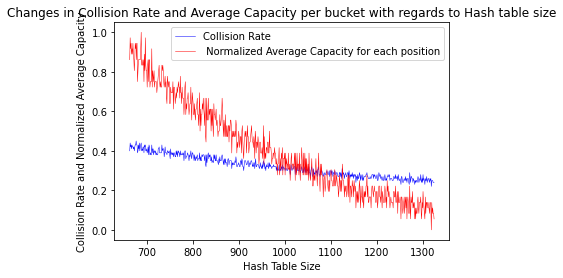

Length of cleaned inputted string 663
Potential sizes: [1319]


In [20]:
import string
import random
import time
import matplotlib.pyplot as plt

letters = string.ascii_lowercase


collision_regular = []
avg_capacity_regular = []
optimal_size = []
x = 'This is an amazing HC to contrast the performance of multiple algorithms by experimental analysis, specifically #ComputationalCritique. \
  With the randoization of the inputs at different lengths, we can reduce the likelihood of worst case, thus increasing the validity of our comparison \
  between the runtime of distinct algorithms. We need the best way to store results of runtime with insanely large inputs and portray the scaling behaviour \
  in running time of algorithms. A data visualization would be most suitable to communicate this message to the audience. This not only simplifies nuances \
  in the scaling behaviour of the algorithms with larger inputs but also captures an intuitive understanding for readers so that audience can easily understand \
  which algorithm works faster in real life. '

y = 'This is a very helpful HC in contrasting the performance between different algorithms by experimental results, specifically #ComputationalCritique. \
  With randomized inputs of different lengths, we can eliminate weird low likelihood of worst case or best case scenarios, thus increasing the validity of \
  our comparison between the runtime of different algorithms. We need the best way to accommodate results of the runtime with insanely large inputs and portray the \
  scaling behaviour in the runtime, a data visualization would be best to communicate this idea to the audience. This not only simplifies different nuances \
  in the scaling behaviour of the algorithm when inputs get bigger but also captures an intuitive understanding for readers so that anyone looking at can \
  understand which algorithm is faster or in real life, when these algorithms deal with thousands of data points, how the runtime growth can become.'


hashtable_sizes = [j for j in range(len(cleaning(x)), len(cleaning(x)) * 2)]

for sizes in hashtable_sizes:
    # store all collision rates and average capacity of buckets into two lists
    avg_capacity_regular.append(collisions(regular_get_match(x, y, 7, size = sizes)[0])[0])
    collision_regular.append(collisions(regular_get_match(x, y, 7, size = sizes)[0])[1])

    # because we examine string matching within the substring's position, we care about low average capacity in a slot
    if collisions(regular_get_match(x, y, 7, size = sizes)[0])[0] <= 1.3:
        optimal_size.append(sizes)

# normalize the range of 0 to 1
avg_capacity_regular = np.array(avg_capacity_regular)
normalized_avg_capacity_regular = (avg_capacity_regular - min(avg_capacity_regular)) / (max(avg_capacity_regular) - min(avg_capacity_regular))

plt.plot(hashtable_sizes, collision_regular, label = 'Collision Rate', color = 'blue', linewidth = 0.5)
plt.plot(hashtable_sizes, normalized_avg_capacity_regular, label = ' Normalized Average Capacity for each position', color = 'red', linewidth = 0.5)
plt.xlabel('Hash Table Size')
plt.ylabel('Collision Rate and Normalized Average Capacity')
plt.title('Changes in Collision Rate and Average Capacity per bucket with regards to Hash table size')
plt.legend()
plt.show()
print("Length of cleaned inputted string", len(cleaning(x)))
print("Potential sizes:", optimal_size)

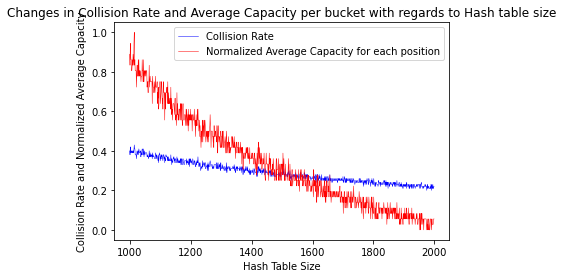

Length of cleaned inputted string 1000
Potential sizes: [1844, 1886, 1890, 1897, 1917, 1927, 1937, 1945, 1946, 1952, 1954, 1955, 1958, 1962, 1965, 1974, 1975, 1976, 1978, 1979, 1980, 1983, 1984, 1985, 1986, 1990, 1991, 1993, 1994, 1995, 1996]


In [21]:
# k = 7
collision_regular = []
avg_capacity_regular = []
optimal_size = []
x = ''.join(random.choice(letters) for i in range(1000))
y = ''.join(random.choice(letters) for i in range(1000))

hashtable_sizes = [j for j in range(len(cleaning(x)), len(cleaning(x)) * 2)]

for sizes in hashtable_sizes:
    # store all collision rates and average capacity of buckets into two lists
    avg_capacity_regular.append(collisions(regular_get_match(x, y, 7, size = sizes)[0])[0])
    collision_regular.append(collisions(regular_get_match(x, y, 7, size = sizes)[0])[1])

    # because we examine string matching within the substring's position, we care about low average capacity in a slot
    if collisions(regular_get_match(x, y, 7, size = sizes)[0])[0] <= 1.25:
        optimal_size.append(sizes)

avg_capacity_regular = np.array(avg_capacity_regular)
normalized_avg_capacity_regular = (avg_capacity_regular - min(avg_capacity_regular)) / (max(avg_capacity_regular) - min(avg_capacity_regular))

plt.plot(hashtable_sizes, collision_regular, label = 'Collision Rate', color = 'blue', linewidth = 0.5)
plt.plot(hashtable_sizes, normalized_avg_capacity_regular, label = 'Normalized Average Capacity for each position', color = 'red', linewidth = 0.5)
plt.xlabel('Hash Table Size')
plt.ylabel('Collision Rate and Normalized Average Capacity')
plt.title('Changes in Collision Rate and Average Capacity per bucket with regards to Hash table size')
plt.legend()
plt.show()
print("Length of cleaned inputted string", len(cleaning(x)))
print("Potential sizes:", optimal_size)

From the two experiments above, the behavior is pretty the same. Both metrics reduce as the hash table size increases. For regular hashing, the hash table size is not necessarily a prime number. 

As the hash table size gets larger, normalized average capacity for each bucket falls significantly while the collision rate is halved when the hash table size doubles the text length. 

From all experiments on both algorithms, I can understand that the larger the hash table size, the fewer collisions happen. However, we need to balance with space consumption. This is when the normalization of average capacity plays out because we can see there will be a sweet spot where more space is no longer worth that reduction in collision rate. Also, because the ideal hash table size will mainly depend on the text length. I can also conclude that we should keep it only twice as large as the string length to both optimize the reduction in collision and save space consumption.

The strength of this analysis can be weakened because we only experiment on strings of 600 or 1000 length which corresponds to a short paragraph. Therefore, we might need more future experiments in the future to examine the ability of our plagiarism detector as well as the validity of choosing a hash table size twice as large as the text length.

In addition, I noticed that there is a constraint in k here to minimize collisions. To elaborate, in our hash value calculation, if k is a large number, then all substrings of the inputs actually will go to the same positions which is the first one. As a result, this points to the worst case scenario of the algorithm which we do not want to. Therefore, I have to conduct more experiments to figure out k = 7 is a better length of the pattern to work on. This constraint might become a limitation of this algorithm because 7 character length can only include around two words, which will be hard to conclude plagiarism.

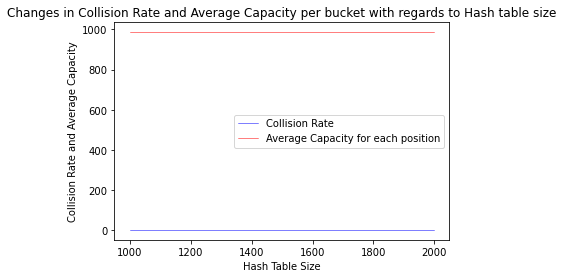

Length of cleaned inputted string 1000
A list of potential sizes: []


In [22]:
# try with k = 15, we will see that all substrings go to one bucket, which is undesirable
collision_regular = []
avg_capacity_regular = []
optimal_size = []
x = ''.join(random.choice(letters) for i in range(1000))
y = ''.join(random.choice(letters) for i in range(1000))

hashtable_sizes = [j for j in range(len(cleaning(x)), len(cleaning(x)) * 2)]

for sizes in hashtable_sizes:
    # store all collision rates and average capacity of buckets into two lists
    avg_capacity_regular.append(collisions(regular_get_match(x, y, 15, size = sizes)[0])[0])
    collision_regular.append(collisions(regular_get_match(x, y, 15, size = sizes)[0])[1])

    # because we examine string matching within the substring's position, we care about low average capacity in a slot
    if collisions(regular_get_match(x, y, 15, size = sizes)[0])[0] <= 1.25:
        optimal_size.append(sizes)

# avg_capacity_regular = np.array(avg_capacity_regular)
# normalized_avg_capacity_regular = (avg_capacity_regular - min(avg_capacity_regular)) / (max(avg_capacity_regular) - min(avg_capacity_regular))

plt.plot(hashtable_sizes, collision_regular, label = 'Collision Rate', color = 'blue', linewidth = 0.5)
plt.plot(hashtable_sizes, avg_capacity_regular, label = 'Average Capacity for each position', color = 'red', linewidth = 0.5)
plt.xlabel('Hash Table Size')
plt.ylabel('Collision Rate and Average Capacity')
plt.title('Changes in Collision Rate and Average Capacity per bucket with regards to Hash table size')
plt.legend()
plt.show()
print("Length of cleaned inputted string", len(cleaning(x)))
print("A list of potential sizes:", optimal_size)

We can see that the average capacity for each position is a line near the value of 1000 because all substrings go to one bucket only, which makes the average capacity become the capacity for this bucket only itself. Furthermore, the collision rate is close to 0, which is actually 1 because the number of overfilled slots equals that of filled slots.

In [23]:
# evidenced by the table

regular_get_match(x, y, 15, size = sizes)[0]

{0: [('kcyjgebmkxydvoj', 0),
  ('cyjgebmkxydvojy', 1),
  ('yjgebmkxydvojyj', 2),
  ('jgebmkxydvojyjk', 3),
  ('gebmkxydvojyjkf', 4),
  ('ebmkxydvojyjkfu', 5),
  ('bmkxydvojyjkfut', 6),
  ('mkxydvojyjkfutc', 7),
  ('kxydvojyjkfutcc', 8),
  ('xydvojyjkfutccl', 9),
  ('ydvojyjkfutccly', 10),
  ('dvojyjkfutcclyc', 11),
  ('vojyjkfutcclycn', 12),
  ('ojyjkfutcclycng', 13),
  ('jyjkfutcclycngl', 14),
  ('yjkfutcclycnglf', 15),
  ('jkfutcclycnglfh', 16),
  ('kfutcclycnglfhk', 17),
  ('futcclycnglfhkb', 18),
  ('utcclycnglfhkbo', 19),
  ('tcclycnglfhkboi', 20),
  ('cclycnglfhkboin', 21),
  ('clycnglfhkboinm', 22),
  ('lycnglfhkboinmt', 23),
  ('ycnglfhkboinmto', 24),
  ('cnglfhkboinmtoi', 25),
  ('nglfhkboinmtoir', 26),
  ('glfhkboinmtoirr', 27),
  ('lfhkboinmtoirrm', 28),
  ('fhkboinmtoirrmn', 29),
  ('hkboinmtoirrmnr', 30),
  ('kboinmtoirrmnrj', 31),
  ('boinmtoirrmnrjq', 32),
  ('oinmtoirrmnrjqv', 33),
  ('inmtoirrmnrjqvu', 34),
  ('nmtoirrmnrjqvux', 35),
  ('mtoirrmnrjqvuxi', 36),
  ('toir

## Question 3: Algorithm Evaluation

1. To investigate the extent to which plagiarism has been committed, we need to do more work on what we already have to understand the plagiarism percentage and where plagiarism occurs. What we currently have is a list of tuples detecting where there will be a match of k-length substrings in two inputs. To build upon this, we need to have a function calculating the percentage of plagiarism. We alsos need to construct a plagiarism distribution plot to understand more clearly which part in two strings witnesses more string similarities

2. Pitfalls and Assumptions:
    The algorithm heavily rests on a few assumptions, which a bit weakens its applicability in practice:
    - In my cleaning string function, I only accept normal letters. This assumes that plagiarism only happens to alphabetical letters, and excludes numbers, uppercase letters, punctuations or even symbols in different languages. As a result, the plagiarism detector cannot work well because it might fail to detect the real plagiarism in other aspects of writing. For example, if I included statistics or figures in my paper with changes in expressions and did not include the in-text citation as well, I should be counted as plagiarism. However, in this plagiarism detector, by eliminating numbers or double quotation marks, different expressions will save me from sufferring plagiarism. In addition, without punctuations, a lot of different meanings will count as one. As a result, plagiarism in this case is entirely wrong.
    
    - Also, the mechanism of this plagiarism detector is to find k-length string matching. In other words, as long as we have k contiguous symbols the same in two strings, this should be part of plagiarism. This does not make sense and may commit false positive. To exemplify, in some topics, there might be overarching key words we will mainly use. For example, regarding environmental sustainability, we will often use words like protection, ecofriendly, reusable or recycle. This will contribute to the plagiarism percentage when using this algorithm. This can be addressed by increasing k. However, as justified above, with large k, the multiplication method will not work effectively. Furthermore, with large k, we might somehow overlook other authentic plagiarism parts. 
    
    - Finally, this algorithm assumes that plagiarism only happens between two strings. This assumes only one source of information to compare the work with. Therefore, in the future, we need to construct multi-source plagiarism detector by activating multi-string matching algorithms. This also serves as a shortcoming of the two above algorithms
    
3. Comparison with brute-force approach:
    - A brute-force approach will compare the first character of the pattern with the first character of the string we want to examine. If this is a match, we move to the second of the pattern and the string. Otherwise, we move to the second character of the string and compare it with the first character of the pattern. We iteratively do it until we go through the whole string and a plagiarism is caught only when there is exactly a pattern found in the string. This method is super computationally expensive and time consuming because we have to check all possible cases.
    
    - Instead, our plagiarism detector computes hash values for each substring and only compares those with the same hash values. This is much more efficient. As we can see in the experimental analysis below, even with 10000 characters, the rolling hashing algorithm still takes less than one second to complete.

## Question 4: Time complexity and Computational Critique

### Time complexity for rolling hashing algorithm: 

Let m, n be the length of two inputted strings: $len(x) = n$, $len(y) = m$. Suppose than $n > m$

- Cleaning inputs: Theta of $(m + n)$
- Compute hash values for k-length x-substrings: $O(n)$
    - The first substring: $O(k)$ because we have to hash every single character
    - The rest: $O(n - k)$ because we are using rolling, we just have to hash the next character

- Find position corresponding to the hash value in the hash table: $O(n - k + 1)$
    - Find position in the hash table for one substring: $O(1)$
    - There are $n - k + 1$ substrings
    
- Compute hash values for k-length y-substrings and find their position in the hash table: $O(m)$
( because $O(m) > O(m - k + 1)$ )
- Suppose we have a matches in one position of the table, we have to compare k-length y-substring with k-length x-substring: $O(ak)$

In the best case scenario, there are no collisions and all substrings of x and y are uniformly distributed to different positions to the hash tables. Therefore, there are no matches and the time complexity will be $O(n+m)$. This can be better written as $O(n)$ given that one string is longer than the other and $(m+n)$ is bounded by $2n$. We can reduce $O(2n)$ to $O(n)$.

In the worst case scenario, this is similar to the naive matching algorithm when all substrings of x and y fall into the same bucket. An example for this is when one string is entirely part of the other string and all k-length substrings are the same. As a result, we have to compare all substrings of x and y together, resulting in a time complexity of $O(m*n)$

In the average case, the result will be $O(m+n)$ or better written as $O(n)$ given that $n > m$ because the hash function should reduce collisions, which makes the number of matches or the length of substring become constant factors and possible to be eliminated.

Therefore, we expect to see a linear runtime in the time complexity of rolling hashing algorithm

### Time complexity for regular hashing algorithm:

The only difference between regular hashing and rolling hashing is in the step of computing hash values for all substrings.

Instead of taking only $O(n)$ time to compute k-length x-substrings, it now takes $O(k * (n - k + 1))$ because in each substring, we have to hash all characters in this k-length substring. The same applies to y-string.

However, because k is only a constant and in asymptotic analysis, we care more about the higher term. Therefore, we can also reduce the time complexity to only $O(n)$ in both best case and average case. In the worst case scenario, with the analysis above, the time complexity will also be $O(m*n)$. 

We also expect a linear runtime of regular hashing for the above analysis. However, we will beware that we already remove more constant factors than we do for rolling hashing. Therefore, though both rolling and regular hashing take linear time, rolling hashing is supposed to take less time with smaller slope.

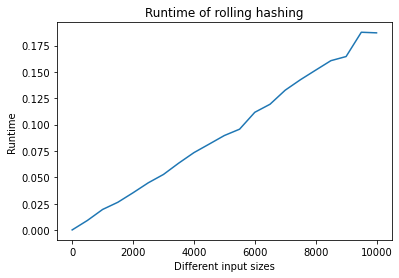

In [24]:
import string
import random
import time
import matplotlib.pyplot as plt

letters = string.ascii_lowercase

k = 15
size = 1319
rolling_runtime = []
input_sizes = [i for i in range(0, 10001, 500)]
for i in input_sizes:
    holder = 0
    for j in range(10):
        # get random text at different lengths
        x = ''.join(random.choice(letters) for i in range(i))
        y = ''.join(random.choice(letters) for i in range(i))

        start = time.time()
        rh_get_match(x, y, k, size)
        end = time.time()
        holder += (end - start)

    # get the average value
    rolling_runtime.append(holder / 10)

plt.plot(input_sizes, rolling_runtime)
plt.xlabel('Different input sizes')
plt.ylabel('Runtime')
plt.title('Runtime of rolling hashing')
plt.show()



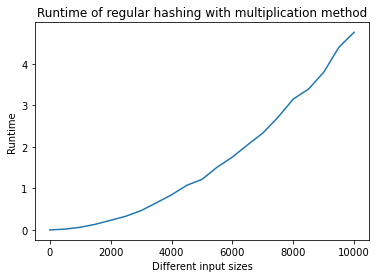

In [25]:
import string
import random
import time
import matplotlib.pyplot as plt
letters = string.ascii_lowercase

k = 15
size = 1319

multiplication = []

input_sizes = [i for i in range(0, 10001, 500)]

for i in input_sizes:
    
    holder_multiplication = 0
    
    for j in range(10):
        # get random text at different lengths
        x = ''.join(random.choice(letters) for iteration in range(i))
        y = ''.join(random.choice(letters) for iteration in range(i))

        start1 = time.time()
        regular_get_match(x, y, k)
        end1 = time.time()
        holder_multiplication += (end1 - start1)

    # get the average value
    multiplication.append(holder_multiplication / 10)
    
plt.plot(input_sizes, multiplication)
plt.xlabel('Different input sizes')
plt.ylabel('Runtime')
plt.title('Runtime of regular hashing with multiplication method')
plt.show()



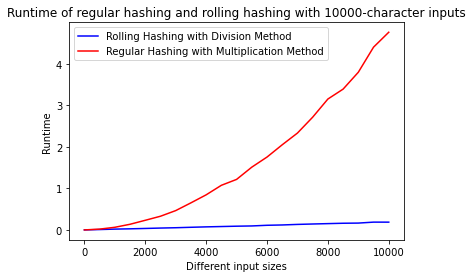

In [26]:
plt.plot(input_sizes, rolling_runtime, color = 'blue', label = 'Rolling Hashing with Division Method')
plt.plot(input_sizes, multiplication, color = 'red', label = 'Regular Hashing with Multiplication Method')
plt.xlabel('Different input sizes')
plt.ylabel('Runtime')
plt.title('Runtime of regular hashing and rolling hashing with 10000-character inputs')
plt.legend()
plt.show()

As expected, both algorithms take linear time to complete, yet with dramatic gaps in the slopes. Rolling hashing is apparently better, especially with larger input sizes. I noticed that at the beginning phase, the two algorithms seems to not differ that much. Therefore, I would love to conduct more experiments to zoom in this plot.

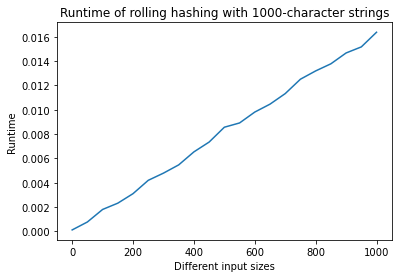

In [27]:
import string
import random
import time
import matplotlib.pyplot as plt

letters = string.ascii_lowercase

k = 15
size = 1319
rolling_runtime = []
input_sizes = [i for i in range(0, 1001, 50)]
for i in input_sizes:
    holder = 0
    for j in range(100):
        x = ''.join(random.choice(letters) for i in range(i))
        y = ''.join(random.choice(letters) for i in range(i))

        start = time.time()
        rh_get_match(x, y, k, size)
        end = time.time()
        holder += (end - start)

    rolling_runtime.append(holder / 100)

plt.plot(input_sizes, rolling_runtime)
plt.xlabel('Different input sizes')
plt.ylabel('Runtime')
plt.title('Runtime of rolling hashing with 1000-character strings')
plt.show()



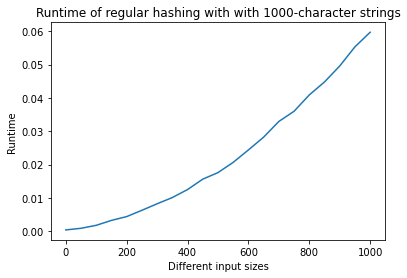

In [28]:
multiplication = []

input_sizes = [i for i in range(0, 1001, 50)]

for i in input_sizes:
    
    holder_multiplication = 0
    
    for j in range(100):
        
        x = ''.join(random.choice(letters) for iteration in range(i))
        y = ''.join(random.choice(letters) for iteration in range(i))

        start1 = time.time()
        regular_get_match(x, y, k)
        end1 = time.time()
        holder_multiplication += (end1 - start1)

    multiplication.append(holder_multiplication / 100)
    
plt.plot(input_sizes, multiplication)
plt.xlabel('Different input sizes')
plt.ylabel('Runtime')
plt.title('Runtime of regular hashing with with 1000-character strings')
plt.show()

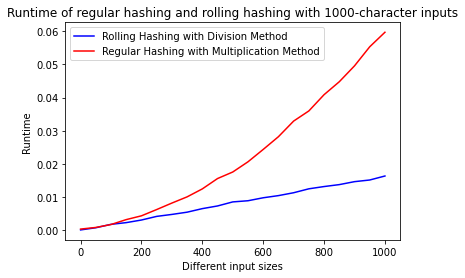

In [29]:
plt.plot(input_sizes, rolling_runtime, color = 'blue', label = 'Rolling Hashing with Division Method')
plt.plot(input_sizes, multiplication, color = 'red', label = 'Regular Hashing with Multiplication Method')
plt.xlabel('Different input sizes')
plt.ylabel('Runtime')
plt.title('Runtime of regular hashing and rolling hashing with 1000-character inputs')
plt.legend()
plt.show()

Linear time starts to become more clear in this graph, especially when I increase iterations to 100, which make the line smoother. With 1000-character inputs, the difference seems noticeable, yet not very considerable because it is only about 0.05-second difference. I would love to understand the algorithms' behavior with small size.

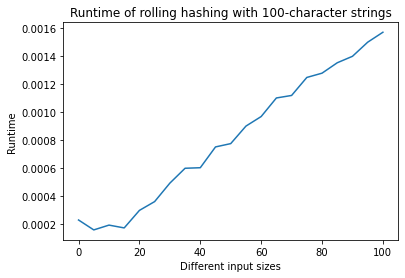

In [30]:
rolling_runtime = []
input_sizes = [i for i in range(0, 101, 5)]
for i in input_sizes:
    holder = 0
    for j in range(500):
        x = ''.join(random.choice(letters) for i in range(i))
        y = ''.join(random.choice(letters) for i in range(i))

        start = time.time()
        rh_get_match(x, y, k, size)
        end = time.time()
        holder += (end - start)

    rolling_runtime.append(holder / 500)

plt.plot(input_sizes, rolling_runtime)
plt.xlabel('Different input sizes')
plt.ylabel('Runtime')
plt.title('Runtime of rolling hashing with 100-character strings')
plt.show()

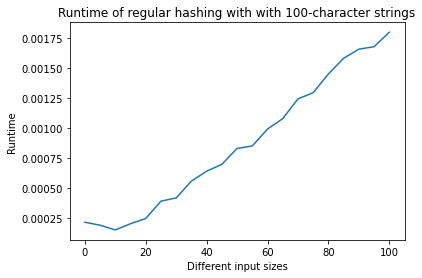

In [31]:
multiplication = []

input_sizes = [i for i in range(0, 101, 5)]

for i in input_sizes:
    
    holder_multiplication = 0
    
    for j in range(500):
        
        x = ''.join(random.choice(letters) for iteration in range(i))
        y = ''.join(random.choice(letters) for iteration in range(i))

        start1 = time.time()
        regular_get_match(x, y, k)
        end1 = time.time()
        holder_multiplication += (end1 - start1)

    multiplication.append(holder_multiplication / 500)
    
plt.plot(input_sizes, multiplication)
plt.xlabel('Different input sizes')
plt.ylabel('Runtime')
plt.title('Runtime of regular hashing with with 100-character strings')
plt.show()

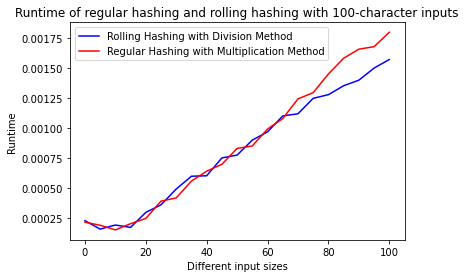

In [32]:
plt.plot(input_sizes, rolling_runtime, color = 'blue', label = 'Rolling Hashing with Division Method')
plt.plot(input_sizes, multiplication, color = 'red', label = 'Regular Hashing with Multiplication Method')
plt.xlabel('Different input sizes')
plt.ylabel('Runtime')
plt.title('Runtime of regular hashing and rolling hashing with 100-character inputs')
plt.legend()
plt.show()

I even increased iterations in this experiment to 500 to make the line less bumpy. As predicted, the two algorithms now do not differ much at the beginning. Only from 60-character length and above, the regular hashing starts to develop greater slope. Therefore, we can consider it to be a threshold.

## Question 5: LO and HC Appendix

### LOs:

1. #PythonProgramming: To get my code running with two algorithms, I tried to take full advantage of functionalities or operations I have learnt, from list manipulation for looping. This helps me so much in achieving my goals. Furthermore, in plotting the graph about two metrics of collision, I used techniques to normalize the whole list to the range from 0 to 1. This is helpful in conveying the behavior of the changes in two metrics.

2. #ComputationalCritique: To contrast the performance of two algorithms, rolling hashing and regular hashing, I tried my best to conduct different experiments on multiple natures of inputs. For both rolling and regular hashing, experiments on 10000 input size help me focus on the scaling behavior of two algorithms when the input sizes can massively big. In addition, to clearly understand the difference and closely engage in the two algorithms' performance, I gradually zoom in the plot with 1000-input size and 100-input size. This sheds light on the suitability of algorithms with different text lengths and helps me judge two algorithms more effectively. In additino, besides the experimental analysis, I also include the strong points of rolling hashing (simple calculation, good runtime, few collisions) as well as its limitations regarding space consumption. Furthermore, I also noticed the constraint of k-length substring in regular hashing because in this hash value computation, large k will not work effectively.

3. #AlgorithmicStrategies: In the first question, I tried my best to describe my algorithmic strategy by dividing it into steps by steps and avoiding using jargon or coding terms. Instead, I used plain text and informal language to describe what the code does so that this will be more understood by the audience. Furthermore, I also focus on the nuances of the problem and justify why it is suitable to choose this algorithmic strategy. Along with that, I also compare the performance of this rolling hashing algorithm with the naive matching algorithm to strengthen the choice of rolling hashing. Comparing with competing alternatives by focusing on the nuances of the problem is such an effective combination of strategy in this scenario.

4. #CodeReadability: With the complementary explanation of HC #composition and #communicationdesign, I tried to include docstrings and code comments effectively and consistently to follow the conventions and help communicate with readers better.

### HCs:

1. #dataviz: In this assignment, I conducted a lot of experiments to not only visualize the behavior of collision rate of each bucket's average capacity when the hash table changes but also contrast the runtime of two algorithms with multiple natures of input sizes. I tried my best to label the plots properly with correct title, axis labelling, color differentiation and effective normalization so that audience can easily understand what I am trying to communicate through these graphs. For example, in the graph about the collision rate and average capacity, I normalize the values of average capacity to the range from 0 to 1 so that viewers can easily identify the changes in two metrics with regards to hash table sizes. There might be a point where the reduction in collision is no longer worth the additional space we have to consume. That's the general idea I want to forewarn future users.

2. #communicationdesign: This assignment requires a lot of coding and experiments. Therefore, to better understand my work, I strategically divided codes into different blocks and different functions. Furthermore, I also included effective comments and markdown letters with different sizes to notify which part I am at. I believe that with clear divisions of different parts in the code and plotting part, viewers can understand better my thought process as well as my algorithm construction and evaluation in general.

3. #composition: I have practiced so long to write things succinctly so that conveying my message can be more effective. This is reflected in code comments and docstring. Sometimes, with complicated lines of code, I believe my comments are helpful with short key words and the docstring will also hep readers understand the general function of the code.